In [33]:
import os
from collections import Counter
from itertools import product
import re
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from textblob import TextBlob
from textstat.textstat import textstat
from langdetect import detect

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [2]:
folder = 'contract_data/Contracts_Annotations/'
xls_files = [f for f in os.listdir(folder) if f.lower().endswith('.xls')]

In [3]:
annotations = pd.DataFrame()
for xls in xls_files:
    temp = pd.read_excel(folder + xls)
    if len(temp) > 0:
        temp['OCID'] = xls[:-4]
        annotations = annotations.append(temp)

In [4]:
print len(annotations)

14951


In [5]:
annotations['Topic'].value_counts()

General                             5230
Fiscal                              3129
Legal Rules                         2376
Operations                          1615
Social                              1546
Environment                         1048
year-contract-signature                2
Infrastructure - third party use       2
Other - general                        1
Infrastructure                         1
Royalties                              1
Name: Topic, dtype: int64

In [6]:
annotations.head(10)

,Category,Topic,Annotation Text,PDF Page Number,Article Reference,OCID
0,Project title,General,Production Sharing Contract between Sociedade ...,1,Preamble,ocds-591adf-0014595575
1,"Name of field, block, deposit or site",General,Block 20/11,1,Preamble,ocds-591adf-0014595575
2,Name of company executing document,General,CIE Angola Block 20 LTD (referred to as Cobalt...,3,Preamble,ocds-591adf-0014595575
3,"State agency, national company or ministry exe...",General,"Sociedade Nacional de Combustiveis de Angola, ...",3,Preamble,ocds-591adf-0014595575
4,Type of contract,General,Production Sharing Contract,3,Preamble,ocds-591adf-0014595575
5,Country,General,Angola,3,Preamble,ocds-591adf-0014595575
6,Parent company or affiliates outside of country,General,"Cobalt, Cayman Islands; BP Exploration Angola ...",3,Preamble,ocds-591adf-0014595575
7,Resource(s),General,Hydrocarbons,4,Preamble,ocds-591adf-0014595575
8,Date of issue of title/permit,General,40909,5,Art. 1.15,ocds-591adf-0014595575
9,Infrastructure,Operations,Contractor Group may construct and install pip...,5,"Arts. 1.18, 19, 20.3, 29.3",ocds-591adf-0014595575


In [70]:
labels = [1 if x.lower() == 'fiscal' else 0 for x in annotations['Topic']]

In [71]:
np.sum(labels) / float(len(labels))

0.20928365995585579

In [9]:
punctuation_re = r'[^\w\s#]'

def punctuation_remove(text):
    """
    Mutates and returns text where all punctuation besides hashtags,
    are replaced
    """
    new_text = nltk.regexp.re.sub(punctuation_re, ' ', text)
    return new_text

def perform_lowercase(text):
    """
    Mutates and returns text where all characters are lowercased
    """
    try:
        new_text = text.lower()
    except:
        new_text = str(text).lower()
    return new_text

def textblobsent(text):
    '''
    returns the TextBlob polarity and subjectivity
    '''
    text = text.encode('ascii','ignore')
    sent = TextBlob(text).sentiment
    return pd.Series([sent.polarity,sent.subjectivity])

def get_length(document):
    return len(document)

def get_num_words(document):
    return len(document.split())

def get_avg_wordlength(document):
    wordlengths = [len(word) for word in document.split()]
    if len(wordlengths) == 0:
        return 0
    else:
        return np.mean(wordlengths)

def get_num_syllables(text):
    '''
    returns the number of syllables
    '''
    return textstat.syllable_count(text)

def determine_tense(essay):
    '''
    Returns the number of past, present and future tense verbs in a given text
    '''
    text = word_tokenize(essay)
    tagged = pos_tag(text)

    numfuture = len([word for word in tagged if word[1] == "MD"])
    numpresent = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    numpast = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    
    return pd.Series([numpast,numpresent,numfuture],index=['NumPast','NumPresent','NumFuture'])

def get_pos_tags(text):
    '''
    Returns part of speech tag counts
    '''
    text = word_tokenize(text)
    tagged = pos_tag(text)

    counts = Counter([word[1] for word in tagged]).items()
    countdict = {}
    for key, value in counts:
        countdict[key] = value  
    
    return countdict

def doublespace_remove(text):
    return re.sub(' +',' ',text)

def detect_lang(text):
    text = doublespace_remove(text)
    try:
        return detect(text)
    except:
        return 'None'

In [10]:
def clean_text(df):
    df['Annotation Text'].fillna('',inplace=True)
    df['CleanText'] = df['Annotation Text']
    func_list = [perform_lowercase,punctuation_remove]
    for func in func_list:
        df['CleanText'] = df['CleanText'].apply(func)

    return df

def featurize(df):
    
    df['NumWords'] = df['CleanText'].apply(get_num_words)
    df['NumCharacters'] = df['CleanText'].apply(get_length)
    df['AvgWordLength'] = df['CleanText'].apply(get_avg_wordlength)
    df['NumSyllables'] = df['CleanText'].apply(get_num_syllables)
    df['Language'] = df['CleanText'].apply(detect_lang)
    
    langdummies = pd.get_dummies(df['Language'])
    df.drop('Language',axis=1,inplace=True)
    tenses = df['CleanText'].apply(determine_tense)
    postagcounts = []
    for index, row in df.iterrows():
        postagcounts.append(get_pos_tags(row['CleanText']))    
    postagdf = pd.DataFrame(postagcounts).fillna(0)
    postagdf.index = df.index
    
    textblobsentdf = df['CleanText'].apply(textblobsent)
    textblobsentdf.columns = ['TextblobPolarity','TextblobSubjectivity']
    df = pd.concat([df,textblobsentdf,tenses,postagdf,langdummies],axis=1)
    
    return df

In [11]:
cleandf = clean_text(annotations)
featurized_df = featurize(cleandf)

In [39]:
stopwordslist = set(stopwords.words('english') + stopwords.words('spanish') +  stopwords.words('french')) 

In [57]:
tfidf_vectorizer = TfidfVectorizer(max_df= .6,
                                 min_df= .002, 
                                 stop_words=stopwordslist,  
                                 use_idf=True, 
                                 ngram_range=(1,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(featurized_df['CleanText'].values.astype('U'))
terms = tfidf_vectorizer.get_feature_names()
tfidf_matrix = tfidf_matrix.todense()
tfidf = pd.DataFrame(tfidf_matrix)
tfidf.index = featurized_df.index
tfidf.columns = terms
print tfidf.shape

(14951, 14568)


In [60]:
exclude = ['Category','Topic','Annotation Text','CleanText',
           'OCID','PDF Page Number','Article Reference','MD','VBP','VBZ','VBG','VBD','VBN']
features = [col for col in featurized_df.columns.tolist() if not col in exclude]

In [61]:
X = pd.concat([tfidf,featurized_df[features]],axis=1)

In [62]:
X.fillna(0,inplace=True)

In [72]:
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [73]:
models = [DummyClassifier(strategy='most_frequent'),
          LogisticRegression(n_jobs=-1),
          RandomForestClassifier(n_estimators=200,max_features = .33, n_jobs=-1,oob_score=True)
         ]

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



**** DummyClassifier ****
0.790867732818


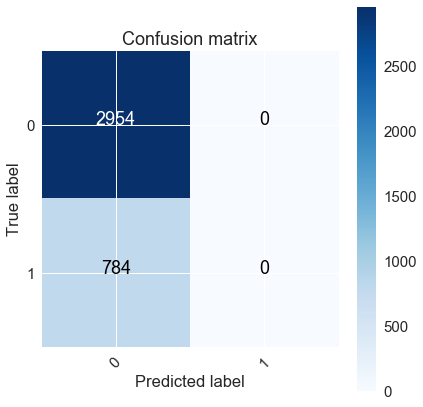



**** LogisticRegression ****
0.957103336259


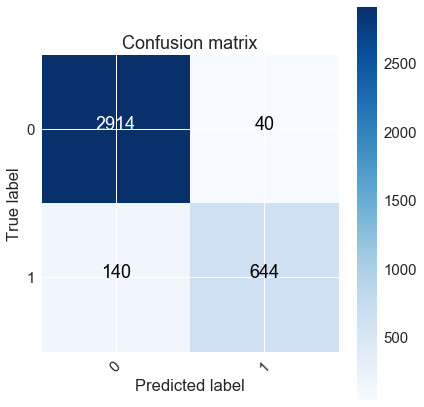



**** RandomForestClassifier ****
0.97360184505


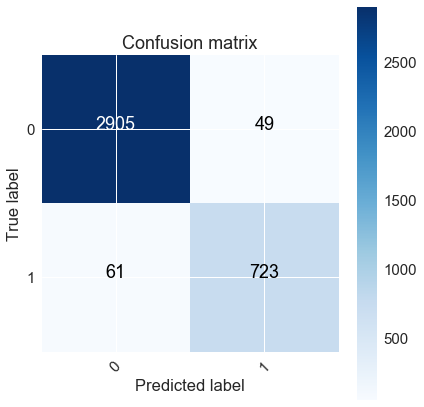

In [75]:
for model in models:
    print '\n'
    print '**** ' + str(model).split('(')[0] + ' ****'
    print np.mean(cross_val_score(model, X_train, y_train, cv=5))
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, test_pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    sns.set_context(rc={"figure.figsize": (6, 6)})       
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=np.unique(y),
                              title='Confusion matrix')

In [76]:
def get_feature_importances(clf,X):
    '''
    returns feature importances
    '''
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_importance = pd.DataFrame(X.columns, importances)    
    feat_importance.reset_index(inplace=True)
    feat_importance.columns = ['Importance','Feature']
    feat_importance.sort_values(by='Importance', axis=0, ascending=True, inplace=True)
    feat_importance.set_index('Feature',inplace=True)
    return feat_importance

In [77]:
importances = {}
importances = get_feature_importances(model,X)
importances.index.name=None
display(importances.sort_values(by='Importance',ascending=False).head(20))

,Importance
tax,0.067586
pay,0.043694
taxes,0.043130
audit,0.037944
taux,0.035235
crude,0.034819
royalty,0.032378
accounts,0.028357
imp,0.025892
crude oil,0.023943
